# Routes

In [ ]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
GA_SCORES_PATH  = 'GA_Scores/'
REPORTS_PATH = 'Reports/'
HYPERPARAMS_PATH = 'Hyperparams/'


# Common methods

In [5]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

# 1 - Imports


In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from imutils import paths
import os
import pickle

# Librerías necesarias para aplicar LBP
from skimage.transform import rotate
from skimage.feature import hog, local_binary_pattern, multiblock_lbp
from skimage import data
from skimage.color import label2rgb
from skimage.transform import integral_image

from skimage.transform import resize

from sklearn.metrics import f1_score, classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
#from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 2 - Variables Goblales

In [ ]:
ROOT_PATH  = './data/INRIAPerson'
TRAIN_PATH = '/Train/'

ext = ['png', 'jpg', 'gif']    # Add image formats here

imagePaths = list(paths.list_images(ROOT_PATH + TRAIN_PATH))

eps=1e-7
numPoints = 24
radius = 8

height = 128
weight = 64

# 3 - Cargamos las Imagenes y Generamos los Embeddings de HOG y LBP

En este apartado cargamos las imagenes, aplicamos los sliding windows para recorrer cada imagen bloque por bloque y calcular sus histogramas, para cada bloque aplicamos **Histogram of Oriented Gradient** (HOG) como clasificador de caracteristicas y **Local Binary Pattern** (LBP) para clasificación de texturas. 

In [ ]:
Extracted_Names = []
Extracted_Embeddings = []

for (i, imagePath) in enumerate(imagePaths):
        if(int(i) >= 10000 and int(i) <= 15000):
          continue
        print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        name = imagePath.split(os.path.sep)[-2]
        img = cv2.imread(imagePath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = resize(gray, (128, 64))
        for i in range(16, height, 16):
          # print("i: " + str(i))
          for j in range(16, weight, 16):
              # print("j: " + str(j))
              box = resized[i-16:i,j-16:j]
              lbp = local_binary_pattern(box, numPoints, radius, method="uniform")
              (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
              # normalize the histogram
              hist = hist.astype("float")
              hist /= (hist.sum() + eps)

              lbp_embedding = hist
              # print("LBP",lbp_embedding.shape)
              hog_embedding = hog(box, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, multichannel=False)
              # print("HOG",hog_embedding.shape)	
              embedding = np.append(hog_embedding.ravel(),lbp_embedding.ravel())
              # print("TOTAL",embedding.shape)	
              Extracted_Names.append(name)
              Extracted_Embeddings.append(embedding)

Extracted_Embeddings = np.array(Extracted_Embeddings)
print(Extracted_Embeddings.shape)
# dump the HOG and LBP embeddings + names to disk
print("[INFO] serializing encodings...")
data = {"embeddings": Extracted_Embeddings, "names": Extracted_Names}
f = open("embeddings.pickle", "wb")
f.write(pickle.dumps(data))
f.close()


Se han truncado las últimas 5000 líneas del flujo de salida.
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
i: 96
j: 16
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 32
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
i: 112
j: 16
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 32
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
[INFO] processing image 527/580
i: 16
j: 16
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 32
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
i: 32
j: 16
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 32
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
i: 48
j: 16
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 32
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
i: 64
j: 16
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 32
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
i: 80
j: 16
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 32
LBP (26,)
HOG (36,)
TOTAL (62,)
j: 48
LBP (26,)
HOG (36,)
TOTAL (62,)
i: 96
j: 16
LBP (26,)
HOG (3

# 4 - Entrenamos el modelo con los Embeddings

Cargaremos los embeddings que guardamos en el disco, entrenaremos el modelo con XGBoost.

In [ ]:
print(type(Extracted_Embeddings))

<class 'numpy.ndarray'>


In [ ]:
# load the embeddings
print("[INFO] loading pictures embeddings...")
data = pickle.loads(open("embeddings.pickle", "rb").read())

# encode the labels
print("[INFO] encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])
print(labels)
# dividing in train and test data
X_train, X_test, y_train, y_test = train_test_split(data["embeddings"], labels, test_size=0.20)

# # train the model used to accept the 3806-d embeddings of the pedestrian and
# # then produce the actual pedestrain recognition
# print("[INFO] training model...")

# xgboost = XGBClassifier()
# xgboost.fit(X_train, y_train)


# print("Accuracy on training set: {:.3f}".format(xgboost.score(X_train, y_train)))
# print("Accuracy on validation set: {:.3f}".format(xgboost.score(X_test, y_test)))

# # write the actual face recognition model to disk
# f = open("classifier.pickle", "wb")
# f.write(pickle.dumps(xgboost))
# f.close()

# # write the label encoder to disk
# f = open("le.pickle", "wb")
# f.write(pickle.dumps(le))
# f.close()

[INFO] loading pictures embeddings...
[INFO] encoding labels...
[INFO] training model...
Accuracy on training set: 0.970
Accuracy on validation set: 0.963


In [ ]:
# xgb_predict = xgboost.predict(X_test)
# xgb_predict

# print(confusion_matrix(y_test,xgb_predict))
# print(classification_report(y_test,xgb_predict))

[[   0   90]
 [   0 2346]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.96      1.00      0.98      2346

    accuracy                           0.96      2436
   macro avg       0.48      0.50      0.49      2436
weighted avg       0.93      0.96      0.94      2436



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
'''
Extracted_Names = []
Extracted_Embeddings = []

eps=1e-7
numPoints = 24
radius = 9

height = 128
weight = 64

#for (k, image) in enumerate(resized_images[0]):
image = resized_images[0]

for i in range(16, height, 16):
	print("i: " + str(i))
	for j in range(16, weight, 16):
			print("j: " + str(j))
			box = image[i-16:i,j-16:j]
			lbp = local_binary_pattern(box, numPoints, radius, method="uniform")
			(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
			# normalize the histogram
			hist = hist.astype("float")
			hist /= (hist.sum() + eps)

			lbp_embedding = hist
			print("LBP",lbp_embedding.shape)
			hog_embedding = hog(box, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, multichannel=False)
			print("HOG",hog_embedding.shape)	
			embedding = np.append(hog_embedding.ravel(),lbp_embedding.ravel())
			print("TOTAL",embedding.shape)	
			#Extracted_Names.append(name)
			Extracted_Embeddings.append(embedding)
	 









#embedding = pca.transform(embedding.reshape(1, -1))  
#prediction = recognizer.predict(embedding.reshape(1, -1))
#cv2.rectangle(nroi,(j,i),(j-121,i-121),(255,0,0),2)
#if(prediction == 1):
#	cv2.rectangle(col,(j,i),(j-39,i-39),(0,0,255),1)
#else:
#	cv2.rectangle(col,(j,i),(j-39,i-39),(0,255,0),1)
#jc+=1
#cv2.imshow('temp2',col)
#cv2.waitKey(1)
		 
#################################################################################

	print("[INFO] processing image {}/{}".format(i + 1,len(image)))
	#name = image.split(os.path.sep)[-2]
	# compute the Local Binary Pattern representation
	# of the image, and then use the LBP representation
	# to build the histogram of patterns\
	hist = local_binary_pattern(image, numPoints, radius, method="uniform")
	(hist, _) = np.histogram(hist.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
	#normalize the histogram
	hist = hist.astype("float")
	hist /= (hist.sum() + eps)
  
	lbp_embedding = hist
	print("LBP",lbp_embedding.shape)
	hog_embedding = hog(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False, multichannel=False)
	print("HOG",hog_embedding.shape)	
	embedding = np.append(hog_embedding.ravel(),lbp_embedding.ravel())
	print("TOTAL",embedding.shape)	
	#Extracted_Names.append(name)
	Extracted_Embeddings.append(embedding)
'''

'\nExtracted_Names = []\nExtracted_Embeddings = []\n\neps=1e-7\nnumPoints = 24\nradius = 9\n\nheight = 128\nweight = 64\n\n#for (k, image) in enumerate(resized_images[0]):\nimage = resized_images[0]\n\nfor i in range(16, height, 16):\n\tprint("i: " + str(i))\n\tfor j in range(16, weight, 16):\n\t\t\tprint("j: " + str(j))\n\t\t\tbox = image[i-16:i,j-16:j]\n\t\t\tlbp = local_binary_pattern(box, numPoints, radius, method="uniform")\n\t\t\t(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))\n\t\t\t# normalize the histogram\n\t\t\thist = hist.astype("float")\n\t\t\thist /= (hist.sum() + eps)\n\n\t\t\tlbp_embedding = hist\n\t\t\tprint("LBP",lbp_embedding.shape)\n\t\t\thog_embedding = hog(box, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, multichannel=False)\n\t\t\tprint("HOG",hog_embedding.shape)\t\n\t\t\tembedding = np.append(hog_embedding.ravel(),lbp_embedding.ravel())\n\t\t\tprint("TOTAL",embedding.shape)\t\n

In [ ]:
print(len(Extracted_Embeddings)*62)

755160


In [ ]:
'''
METHOD = 'uniform'
plt.rcParams['font.size'] = 16


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(16),
                   np.ones(16),
                   np.hstack([np.ones(12), np.zeros(12)]),
                   np.hstack([np.zeros(12), np.ones(12)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)
'''

'\nMETHOD = \'uniform\'\nplt.rcParams[\'font.size\'] = 16\n\n\ndef plot_circle(ax, center, radius, color):\n    circle = plt.Circle(center, radius, facecolor=color, edgecolor=\'0.5\')\n    ax.add_patch(circle)\n\n\ndef plot_lbp_model(ax, binary_values):\n    """Draw the schematic for a local binary pattern."""\n    # Geometry spec\n    theta = np.deg2rad(45)\n    R = 1\n    r = 0.15\n    w = 1.5\n    gray = \'0.5\'\n\n    # Draw the central pixel.\n    plot_circle(ax, (0, 0), radius=r, color=gray)\n    # Draw the surrounding pixels.\n    for i, facecolor in enumerate(binary_values):\n        x = R * np.cos(i * theta)\n        y = R * np.sin(i * theta)\n        plot_circle(ax, (x, y), radius=r, color=str(facecolor))\n\n    # Draw the pixel grid.\n    for x in np.linspace(-w, w, 4):\n        ax.axvline(x, color=gray)\n        ax.axhline(x, color=gray)\n\n    # Tweak the layout.\n    ax.axis(\'image\')\n    ax.axis(\'off\')\n    size = w + 0.2\n    ax.set_xlim(-size, size)\n    ax.set_yli

In [ ]:
'''
# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


#image = cv2.cvtColor(resized_images[256], cv2.COLOR_BGR2GRAY)
lbp = local_binary_pattern(gray, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(gray, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')
'''

"\n# settings for LBP\nradius = 3\nn_points = 8 * radius\n\n\ndef overlay_labels(image, lbp, labels):\n    mask = np.logical_or.reduce([lbp == each for each in labels])\n    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)\n\n\ndef highlight_bars(bars, indexes):\n    for i in indexes:\n        bars[i].set_facecolor('r')\n\n\n#image = cv2.cvtColor(resized_images[256], cv2.COLOR_BGR2GRAY)\nlbp = local_binary_pattern(gray, n_points, radius, METHOD)\n\n\ndef hist(ax, lbp):\n    n_bins = int(lbp.max() + 1)\n    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),\n                   facecolor='0.5')\n\n\n# plot histograms of LBP of textures\nfig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))\nplt.gray()\n\ntitles = ('edge', 'flat', 'corner')\nw = width = radius - 1\nedge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)\nflat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))\ni_14 = n_points // 4            # 

# Genetic Algorithm

## Initialize Population

In [ ]:
def initilialize_poplulation(numberOfParents):

    maxDepth   = np.empty([numberOfParents, 1], dtype = np.uint8)
    regAlpha   = np.empty([numberOfParents, 1])
    regLambda  = np.empty([numberOfParents, 1])
    gammaValue = np.empty([numberOfParents, 1])
    subSample  = np.empty([numberOfParents, 1])
    learningRate = np.empty([numberOfParents, 1])
    nEstimators  = np.empty([numberOfParents, 1], dtype = np.uint8)
    minChildWeight  = np.empty([numberOfParents, 1])
    colSampleByTree =  np.empty([numberOfParents, 1])

    # space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),
#         'tree_method': 'gpu_hist'
#     }
    for i in range(numberOfParents):
        # learningRate[i] = round(random.uniform(0.01, 1), 2)
        # nEstimators[i] = random.randrange(100, 2000, step = 150)
        # maxDepth[i] = int(random.randrange(1, 20, step= 1))
        # minChildWeight[i] = round(random.uniform(0.01, 15.0), 1)
        # gammaValue[i] = round(random.uniform(0.01, 10.0), 2)
        # subSample[i] = round(random.uniform(0.01, 1.0), 2)
        # colSampleByTree[i] = round(random.uniform(0.01, 1.0), 2)
        # regAlpha[i]  = round(random.uniform(40,180), 1)
        # regLambda[i] = round(random.uniform(0,1), 3)
        
        learningRate[i] = round(random.uniform(0.01, 1), 2)
        maxDepth[i] = int(random.randrange(1, 20, step= 1))
        minChildWeight[i] = round(random.uniform(0.01, 15.0), 1)

    
    # population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree, regAlpha, regLambda), axis= 1)
    population = np.concatenate((learningRate, maxDepth, minChildWeight), axis= 1)
  
    return population

## Fitness Function

In [2]:
from sklearn.metrics import roc_curve, auc

def fitness_f1score(y_true, y_pred):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    
    fitness = round(auc(fpr, tpr), 4)

    return fitness # Train the data annd find fitness score

## Evaluate Population

In [3]:
from xgboost import XGBClassifier

def train_population(population, dMatrixTrain, dMatrixTest, y_test):
    fScore = []
    for i in range(population.shape[0]):
        # param = { 'objective':'multi:softprob',
        #           'tree_method': 'gpu_hist',
        #           'num_class': 3,
        #           'learning_rate': population[i][0],
        #           'n_estimators': population[i][1], 
        #           'max_depth': int(population[i][2]), 
        #           'min_child_weight': population[i][3],
        #           'gamma': population[i][4], 
        #           'subsample': population[i][5],
        #           'colsample_bytree': population[i][6],
        #           'reg_alpha': population[i][7],
        #           'reg_lambda': population[i][8]
        #         }

        param = { 'objective':'multi:softprob',
                  'tree_method': 'gpu_hist',
                  'num_class': 3,
                  'learning_rate': population[i][0],
                  'max_depth': int(population[i][1]), 
                  'min_child_weight': population[i][2]
                }

        num_round = 100
        xgb.set_config(verbosity=0)
        xgbT = xgb.train(param,
                         dMatrixTrain,
                         num_round)

        preds = xgbT.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5

        fScore.append(fitness_f1score(y_test, single_predictions))

    return fScore

ModuleNotFoundError: No module named 'xgboost'

## Parents Selection

In [ ]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.
    
    # Find the top best performing parents
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

## Population Crossover

In [ ]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

## Childs Mutation

In [ ]:
def mutation(crossover, numberOfParameters):
    # Define minimum and maximum values allowed for each parameterminMaxValue = np.zeros((numberOfParameters, 2))
    minMaxValue = np.zeros((numberOfParameters, 2))

    minMaxValue[0:]  = [0.01, 1.0]  # min/max learning rate
    minMaxValue[1,:] = [1, 15]      # min/max depth
    minMaxValue[2,:] = [0, 10.0]    # min/max child_weight
 
    # Mutation changes a single gene in each offspring randomly.
    mutationValue = 0
    parameterSelect = np.random.randint(0, numberOfParameters, 1)

    print(parameterSelect)

    if parameterSelect == 0: # learning_rate
        # mutationValue = round(np.random.uniform(-0.2, 0.2), 2)
        mutationValue = round(random.uniform(-0.1, 0.1), 3)
    if parameterSelect == 1: # max_depth
        # mutationValue = np.random.randint(-3, 3, 1)
        mutationValue = int(random.randrange(-3, 3, step= 1))
    if parameterSelect == 2: # min_child_weight
        # mutationValue = round(np.random.uniform(5, 5), 2)
        mutationValue = round(random.uniform(-5, 5), 1)


    # Introduce mutation by changing one parameter, and set to max or min if it goes out of range
    for idx in range(crossover.shape[0]):
        crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue

        if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]

        if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]

    return crossover

## Main Function

In [4]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test  = sc.transform(X_test)

# XGboost Classifier
# model xgboost
# use xgboost API now

import xgboost as xgb
import random

# X_train, X_test, y_train, y_test = train_test_split(data["embeddings"], labels, test_size=0.20)

numberOfParents = 40 # number of parents to start
numberOfParentsMating = 20 # Number of parents that will mate
numberOfParameters = 3  # Number of parameters that will be optimized
numberOfGenerations = 100 # Number of genration that will be created 

# Define the population size
populationSize = (numberOfParents, numberOfParameters) # initialize the population with randomly generated parameters

population = initilialize_poplulation(numberOfParents) # Define an array to store the fitness  hitory
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents]) # Define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters]) # Insert the value of initial parameters in history

populationHistory[0:numberOfParents, :] = population

for generation in range(numberOfGenerations):
    print("This is number %s generation" % (generation))

    xgbDMatrixTrain = xgb.DMatrix(data = X_train, label = y_train)
    xgbDMatrixTest  = xgb.DMatrix(data = X_test, label = y_test)
    
    # Train the dataset and obtain fitness
    fitnessValue = train_population(population = population,
                                    dMatrixTrain = xgbDMatrixTrain,
                                    dMatrixTest =  xgbDMatrixTest,
                                    y_test = y_test)

    fitnessHistory[generation, :] = fitnessValue
    
    # Best score in the current iteration
    print('Best F1 score in the this iteration = {}'.format(np.max(fitnessHistory[generation, :]))) # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    
    parents = new_parents_selection(population = population,
                                    fitness = fitnessValue,
                                    numParents = numberOfParentsMating)
    
    # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
    children = crossover_uniform(parents = parents,
                                 childrenSize = (populationSize[0] - parents.shape[0], numberOfParameters))
    
    # Add mutation to create genetic diversity
    children_mutated = mutation(children, numberOfParameters)
    
    '''
    We will create new population, which will contain parents that where selected previously based on the
    fitness score and rest of them  will be children
    '''
    population[0:parents.shape[0], :] = parents # Fittest parents
    population[parents.shape[0]:, :] = children_mutated # Children
    
    populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population # Srore parent information
    
#Best solution from the final iteration

fitness = train_population(population = population,
                           dMatrixTrain = xgbDMatrixTrain,
                           dMatrixTest  = xgbDMatrixTest,
                           y_test = y_test)

fitnessHistory[generation+1, :] = fitness # index of the best solution
bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


ModuleNotFoundError: No module named 'xgboost'

FileNotFoundError: ignored

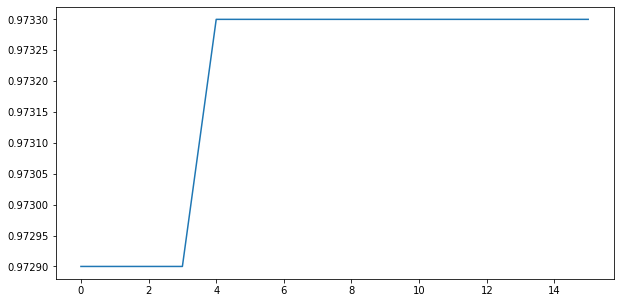

In [ ]:
x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

best_hyperparams = {}
best_hyperparams['eta'] = population[bestFitnessIndex][0]
best_hyperparams['max_depth'] = int(population[bestFitnessIndex][1])
best_hyperparams['min_child_weight'] = population[bestFitnessIndex][2]

FILE_NAME = 'XGBoost_' + MODEL_TIMESTAMP  + '.jpg'

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(x_fitness)), x_fitness)
plt.savefig(GA_SCORES_PATH + FILE_NAME)

In [ ]:
FILE_NAME = 'hyperparams_' + MODEL_TIMESTAMP + '.json'

write_json(best_hyperparams, HYPERPARAMS_PATH, FILE_NAME)
print(best_hyperparams)

## Train XGBoost with Besthyperparams

In [ ]:
from xgboost import XGBClassifier

# xgboost = XGBClassifier(eta = 0.78,
#                         max_depth = 15,
#                         min_child_weight = 0.8,
#                         tree_method = 'gpu_hist')

xgboost = XGBClassifier(eta = best_hyperparams['eta'],
                        max_depth = best_hyperparams['max_depth'],
                        min_child_weight = best_hyperparams['min_child_weight'],
                        tree_method = 'gpu_hist')

xgboost.fit(X_train, y_train)

XGBClassifier(eta=0.78, max_depth=15, min_child_weight=0.8,
              tree_method='gpu_hist')

In [ ]:
y_pred = xgboost.predict(X_test)

target_names = ['Negativo', 'Positivo']

report = classification_report(y_test, y_pred, target_names=target_names, output_dict = True)
report_df = pd.DataFrame(report).transpose()

display(report_df)

REPORT_NAME  = 'report_' + MODEL_TIMESTAMP + '.csv'

report_df.to_csv(REPORTS_PATH + REPORT_NAME, index= True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Negativo,0.000000,0.000000,0.000000,90.000000
Positivo,0.963054,1.000000,0.981179,2346.000000
accuracy,0.963054,0.963054,0.963054,0.963054
macro avg,0.481527,0.500000,0.490590,2436.000000
weighted avg,0.927473,0.963054,0.944929,2436.000000


FileNotFoundError: ignored